#Please install these libraries or update them for use at ease.

```
pip install statsmodels
pip install scikit-learn
pip install seaborn
pip install numpy
pip install pandas
pip install tensorflow
pip install tqdm
!pip install statsmodels
!pip install scikit-learn
!pip install seaborn
!pip install numpy
!pip install pandas
!pip install tensorflow
!pip install tqdm
```



In [143]:

from statsmodels.tsa.stattools import acf, pacf
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from statsmodels.stats.diagnostic import acorr_ljungbox
import numpy as np
from statsmodels.tsa.stattools import adfuller
import itertools
import statsmodels.api as sm
import tensorflow as tf
from sklearn import preprocessing
from tensorflow import keras
import pandas as pd
import math
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.layers import Dense, Activation
from sklearn.metrics import mean_squared_error as mse
from keras.models import Sequential
import concurrent.futures
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [144]:
def process_data(path, countries=[], panel=True):
    df = pd.read_excel(path)
    df=df.set_index('Date')


    return df[countries]

data = process_data('population_data.xlsx',['France','Japan','Zambia','Usa'], True)
data = np.log(data).pct_change()

In [180]:
data

,France,Japan,Zambia,Usa
Date,,,,
2016-09-01,0.000078,-0.000142,0.000000,0.000123
2016-10-01,0.000074,-0.000033,0.000000,0.000113
2016-11-01,0.000059,-0.000045,0.000000,0.000103
2016-12-01,0.000048,-0.000051,0.000000,0.000096
2017-01-01,0.000019,0.000094,0.010530,0.000084
...,...,...,...,...
2023-01-01,0.000011,-0.000014,0.009522,0.000058
2023-02-01,0.000018,-0.000294,0.000000,0.000053
2023-03-01,0.000051,-0.000154,0.000000,0.000060


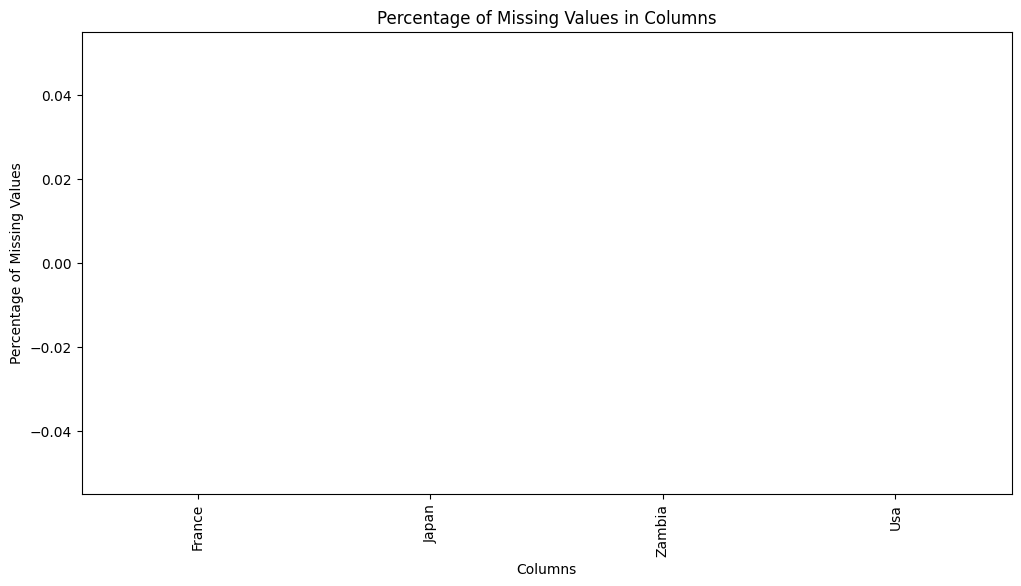

In [147]:
def plot_nan_percentage(data):
    nan_percentage = (data.isnull().sum() / len(data)) * 100
    nan_percentage = nan_percentage[nan_percentage >=0]  # Filter out columns with no missing values

    # Plotting
    plt.figure(figsize=(12, 6))
    nan_percentage.sort_values(ascending=False).plot(kind='bar')
    plt.title('Percentage of Missing Values in Columns')
    plt.xlabel('Columns')
    plt.ylabel('Percentage of Missing Values')
    plt.show()


plot_nan_percentage(data)

Country : France, From 2016-09-01 00:00:00 to  2023-05-01 00:00:00
Country : Japan, From 2016-09-01 00:00:00 to  2023-05-01 00:00:00
Country : Zambia, From 2016-09-01 00:00:00 to  2023-05-01 00:00:00
Country : Usa, From 2016-09-01 00:00:00 to  2023-05-01 00:00:00


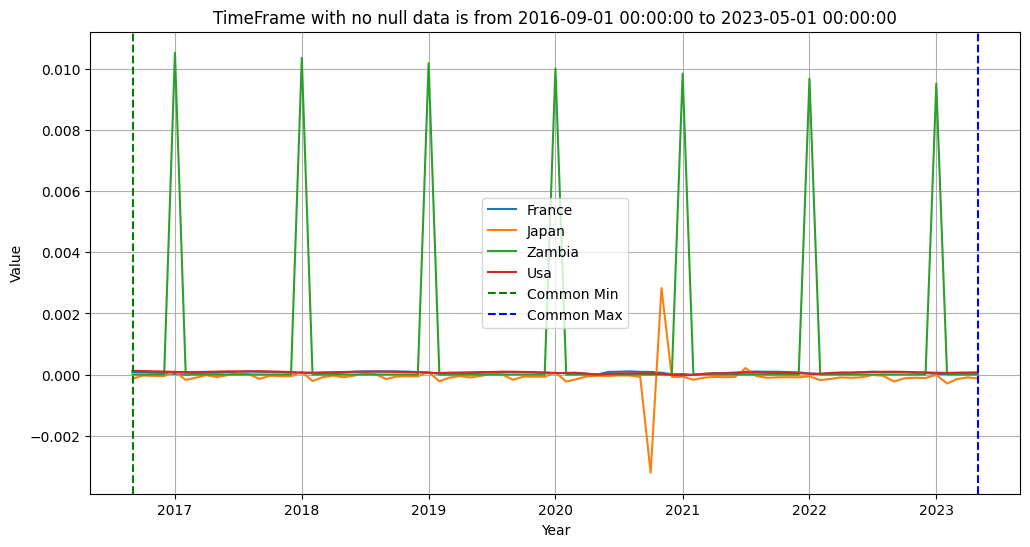

In [148]:
def nan_intime(output):
    missing_data = output.isnull()

    # Find the common time frame (min and max)
    treshold=output.dropna()
    common_min = treshold.index.min()
    common_max = treshold.index.max()

    # Create a line plot with missing data highlighted
    plt.figure(figsize=(12, 6))

    for country in output.columns:
        plt.plot(output.index, output[country], label=country)

    # Highlight missing data in red
    for country in output.columns:
        plt.scatter(output.index[missing_data[country]], output[country][missing_data[country]], c='red', s=10)
        print(f'Country : {country}, From {output[country].dropna().index.min()} to  {output[country].dropna().index.max()}')

    # Add a vertical line for the common time frame
    plt.axvline(common_min, color='green', linestyle='--', label='Common Min')
    plt.axvline(common_max, color='blue', linestyle='--', label='Common Max')

    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.title(f'TimeFrame with no null data is from {common_min} to {common_max}')
    plt.legend()
    plt.grid()
    plt.show()


# Example usage
nan_intime(data)


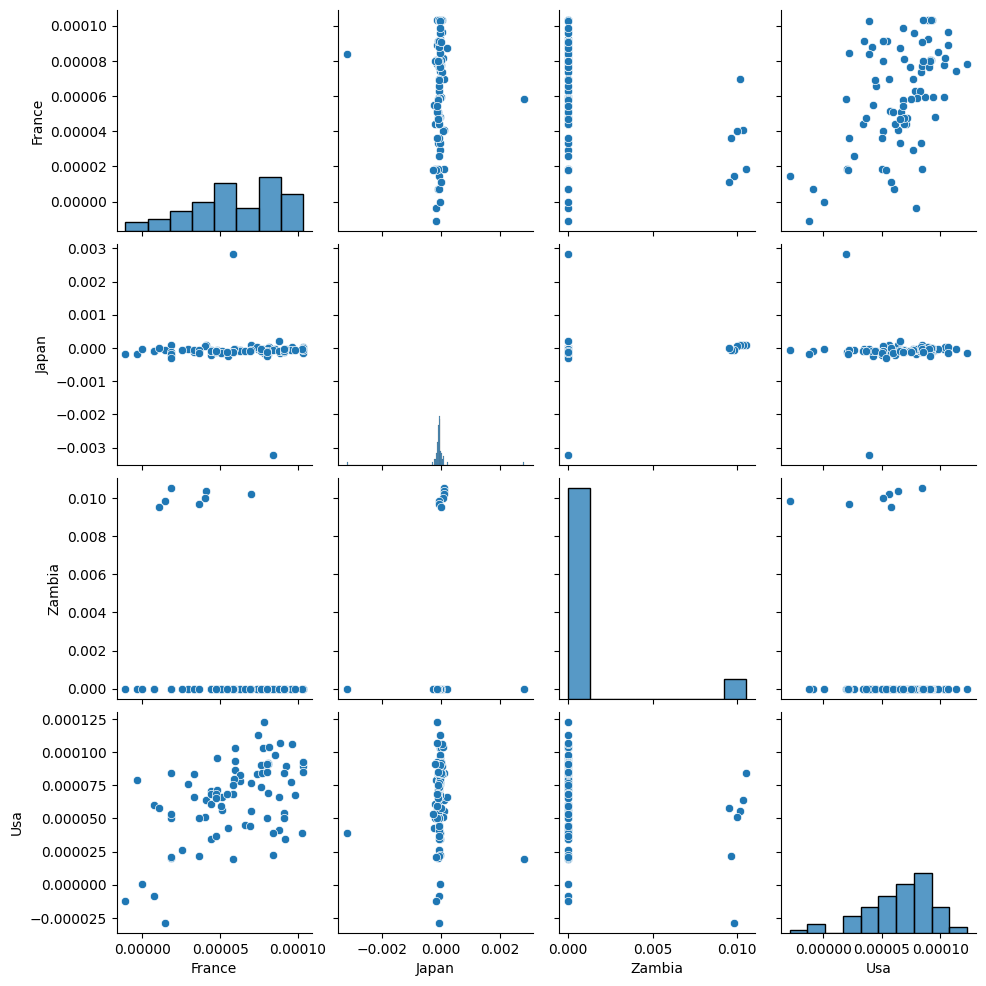

In [149]:
sns.pairplot(data)

## Take the log of the level data


## Check the series for stationnarity
Most of the series are not stationnary at the first difference except for the Total World Population, the rest of the country level data is stationnary at the second difference.


In [150]:

def determine_differencing_order_for_all(data):
    stat={}
    for column in data.columns:
        series = data[column].dropna()
        d = 0

        while True:
            # Perform Augmented Dickey-Fuller test for stationarity
            result = adfuller(series)

            print(f"Results for column '{column}' (I({d})):")
            print(f"ADF Statistic: {result[0]}")
            print(f"P-Value: {result[1]}")
            print("Critical Values:")
            for key, value in result[4].items():
                print(f"  {key}: {value}")

            if result[1] <= 0.05:
                print(f"Series '{column}' is stationary at order I({d}) (reject null hypothesis)")
                break
            else:
                print(f"Series '{column}' is non-stationary at order I({d}) (fail to reject null hypothesis)")
                d += 1
                series = series.diff().dropna()  # Differencing the series
            print('\n')
        stat[column]=d

    return(stat)
# Example usage:
# Assuming you have a DataFrame 'data' with columns containing time series data
orders =determine_differencing_order_for_all(data)


Results for column 'France' (I(0)):
ADF Statistic: -6.612786559308986
P-Value: 6.3154320235366586e-09
Critical Values:
  1%: -3.520713130074074
  5%: -2.9009249540740742
  10%: -2.5877813777777776
Series 'France' is stationary at order I(0) (reject null hypothesis)
Results for column 'Japan' (I(0)):
ADF Statistic: -7.367546600880278
P-Value: 9.151824656164137e-11
Critical Values:
  1%: -3.518281134660583
  5%: -2.899878185191432
  10%: -2.5872229937594873
Series 'Japan' is stationary at order I(0) (reject null hypothesis)
Results for column 'Zambia' (I(0)):
ADF Statistic: -2.0677615263226508
P-Value: 0.25767382477621886
Critical Values:
  1%: -3.528889992207215
  5%: -2.9044395987933362
  10%: -2.589655654274312
Series 'Zambia' is non-stationary at order I(0) (fail to reject null hypothesis)


Results for column 'Zambia' (I(1)):
ADF Statistic: -21571.2695766881
P-Value: 0.0
Critical Values:
  1%: -3.528889992207215
  5%: -2.9044395987933362
  10%: -2.589655654274312
Series 'Zambia' is 

In [151]:
orders

{'France': 0, 'Japan': 0, 'Zambia': 1, 'Usa': 2}

## Decompose the series and study the seasonaility


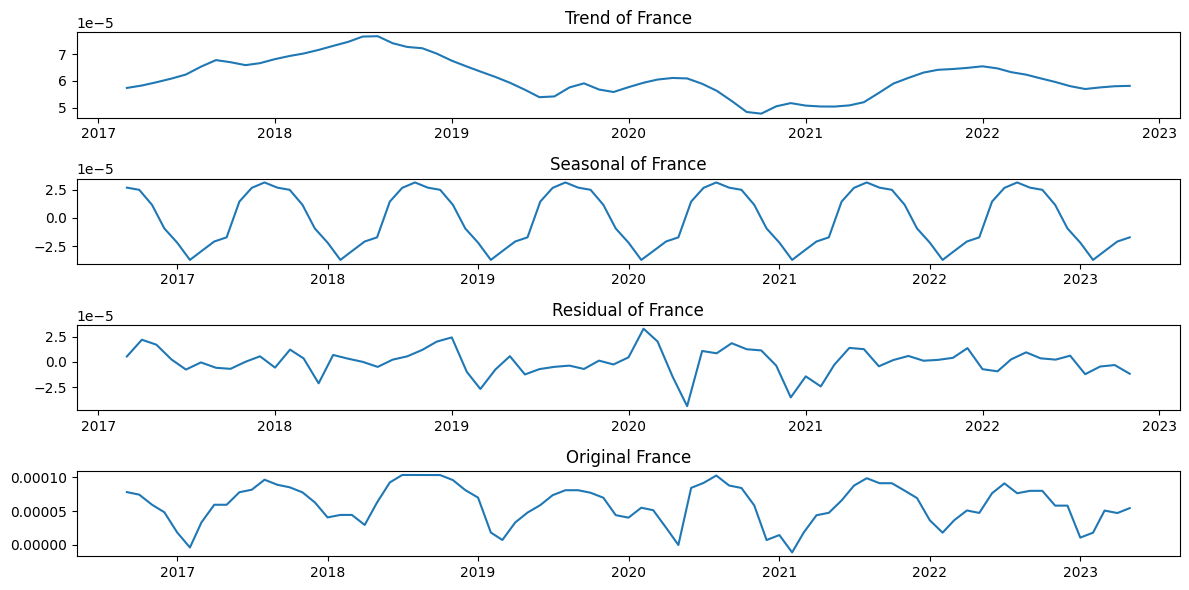

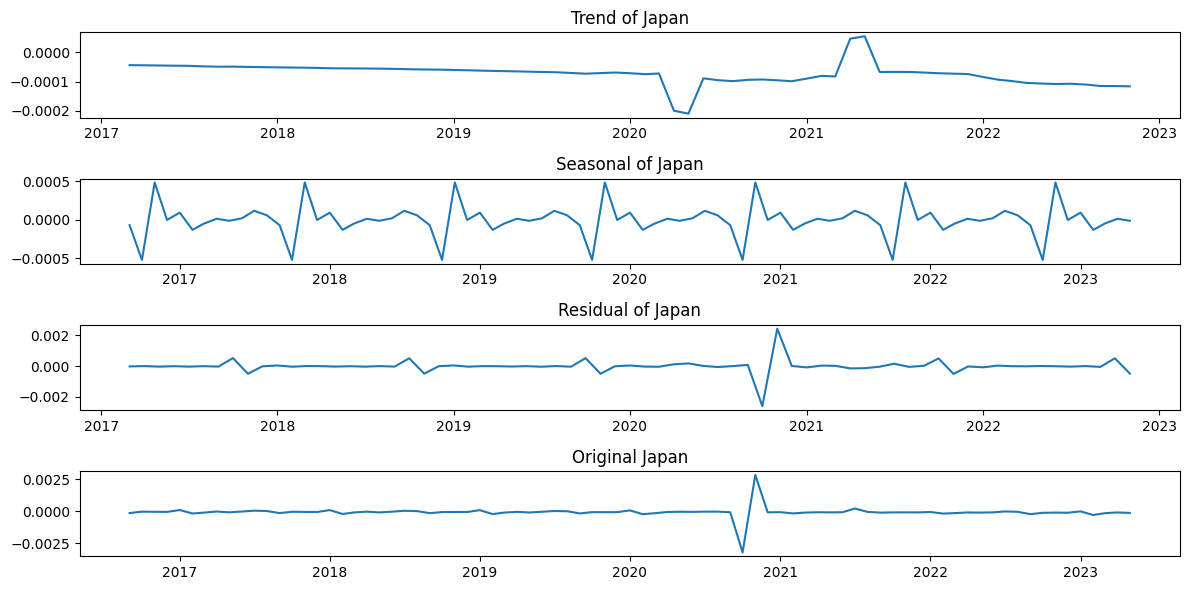

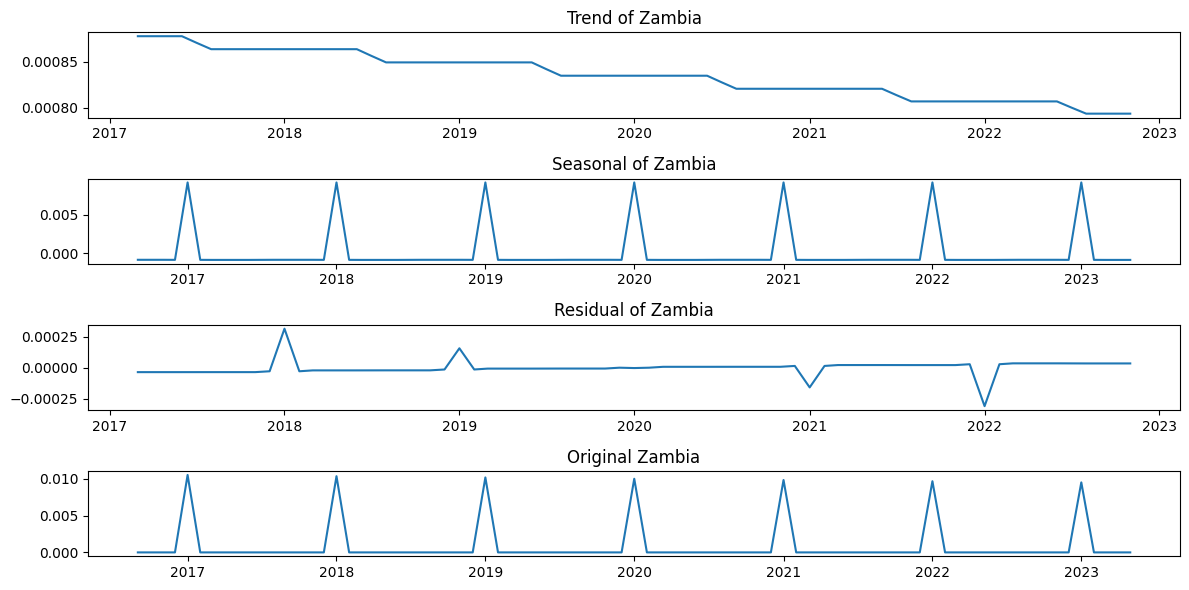

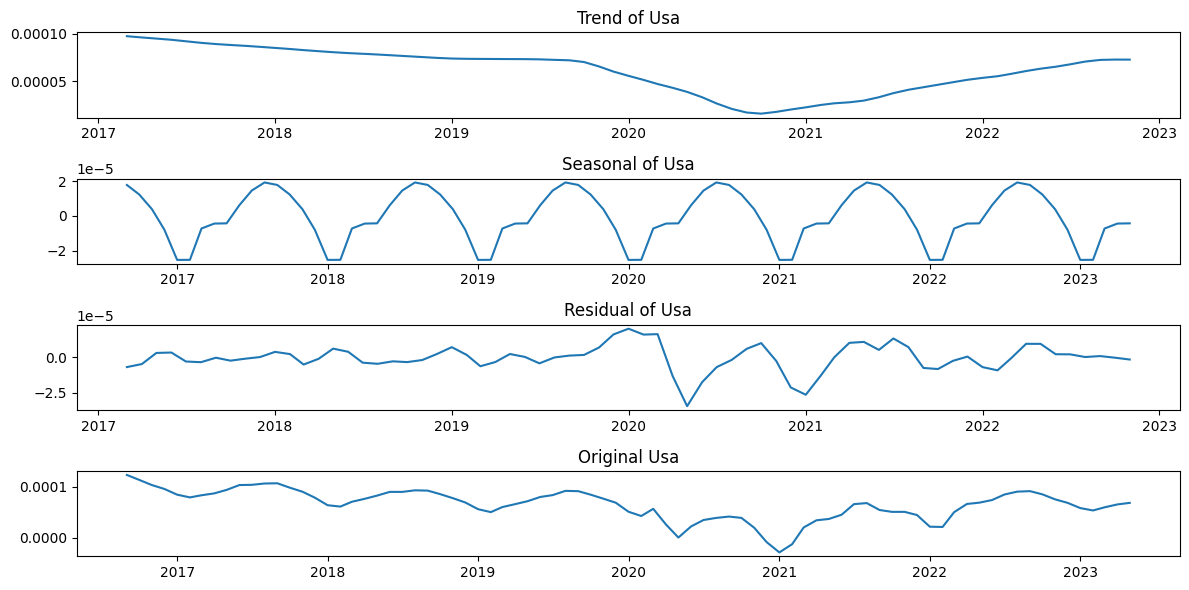

In [152]:
#

def decompose_data(data):
    decomposed_data = {}

    for column in data.columns:
        # Decompose the time series
        decomposition = sm.tsa.seasonal_decompose(data[column].dropna(), model='additive')

        # Store the decomposition components in a dictionary
        decomposed_data[column] = {
            'trend': decomposition.trend,
            'seasonal': decomposition.seasonal,
            'residual': decomposition.resid
        }

        # Visualize the decomposed components
        plt.figure(figsize=(12, 6))
        plt.subplot(411)
        plt.plot(decomposed_data[column]['trend'])
        plt.title(f'Trend of {column}')
        plt.subplot(412)
        plt.plot(decomposed_data[column]['seasonal'])
        plt.title(f'Seasonal of {column}')
        plt.subplot(413)
        plt.plot(decomposed_data[column]['residual'])
        plt.title(f'Residual of {column}')
        plt.subplot(414)
        plt.plot(data[column])
        plt.title(f'Original {column}')
        plt.tight_layout()
        plt.show()

    return decomposed_data

# Example usage
decomposed_data = decompose_data(data)


In [89]:
orders

{'France': 0, 'Japan': 0, 'Zambia': 1, 'Usa': 2}

## Fitting an AR(1) on the I(n) of the Series
orders contains the I(n), n being the order at which stationarity is stable.

#Define Maximum AR and MA Orders:
Locate the max_ar and max_ma variables in the code. These represent the maximum AutoRegressive (AR) and Moving Average (MA) orders, respectively.
  Modify these values based on your preferences. A higher max_ar allows for more complex AR components, while max_ma does the same for MA components.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

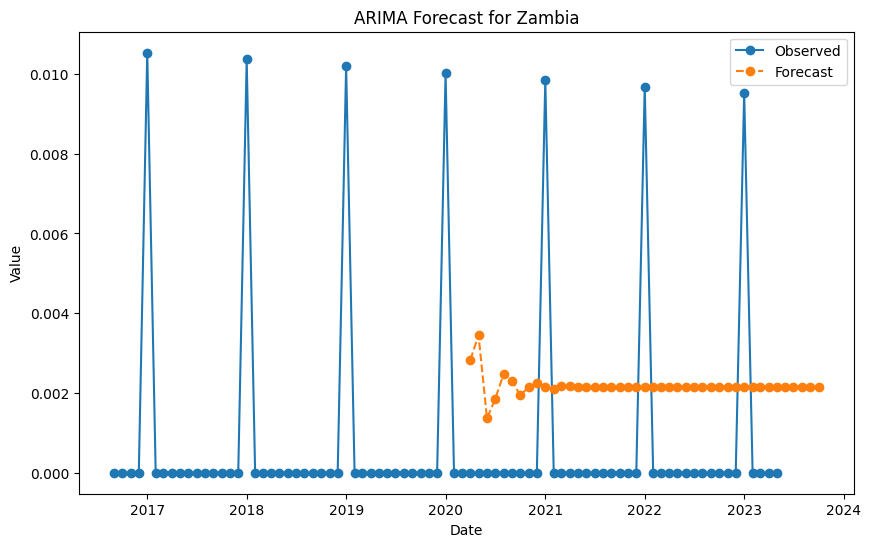

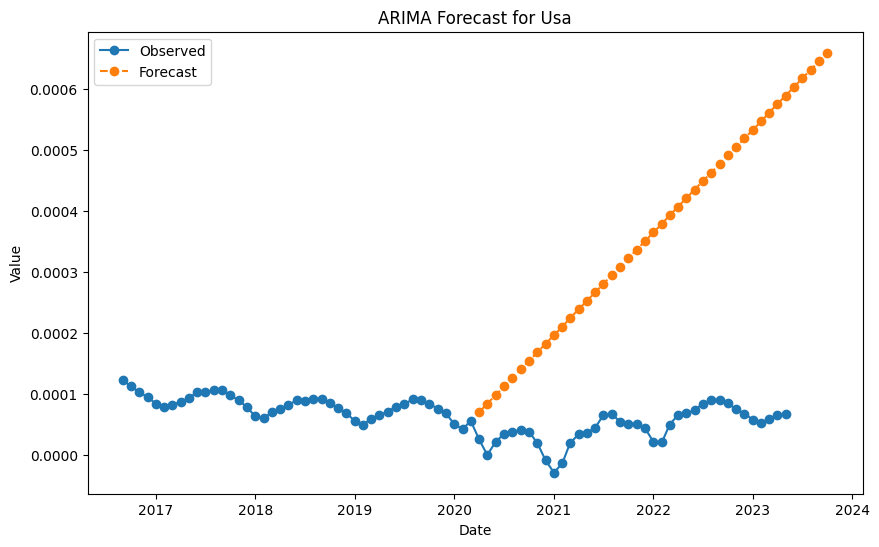

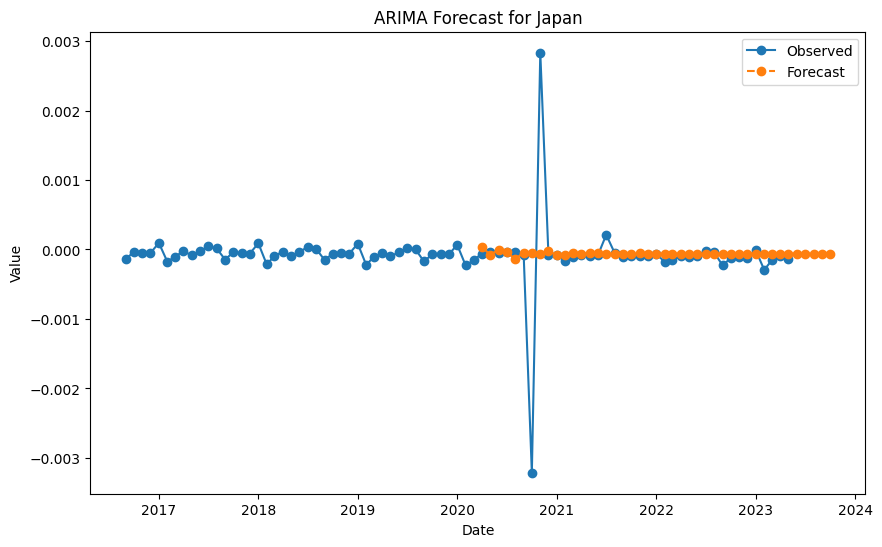

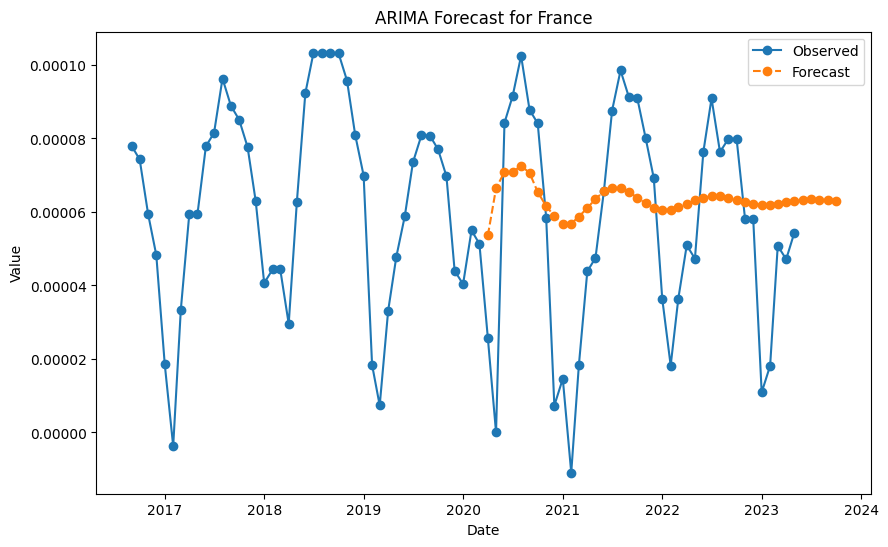

In [153]:




def find_best_order_single_column(column, series, max_ar, max_ma, cutoff_date, d):
    best_order = None
    best_aic = float('inf')

    for p in range(0, max_ar + 1):
        for q in range(0, max_ma + 1):
            training_data = series[series.index <= cutoff_date]
            testing_data = series[series.index > cutoff_date]

            model = ARIMA(training_data, order=(p, d, q))
            arima_model = model.fit()
            aic = arima_model.aic

            if aic < best_aic:
                best_aic = aic
                best_order = (p, d, q)

    return column, best_order

def find_best_orders(data, max_ar, max_ma, cutoff_date, diff_orders):
    best_orders = {}
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for column in data.columns:
            series = data[column].dropna()
            d = diff_orders.get(column, 0)  # Use the pre-determined 'd' from the 'orders' dictionary
            futures.append(executor.submit(find_best_order_single_column, column, series, max_ar, max_ma, cutoff_date, d))

        # Use tqdm to display a progress bar
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Finding best orders"):
            column, order = future.result()
            best_orders[column] = order
    return best_orders

def ARIMA_forecast(data, best_orders, cutoff=None):
    if cutoff is None:
        cutoff_date = pd.to_datetime('2020-03-01')
    else:
        cutoff_date = pd.to_datetime(cutoff)

    arima_models = {}

    for column, order in best_orders.items():
        series = data[column]

        p, d, q = order

        # Split the data into training and testing based on the cutoff date
        training_data = series[series.index <= cutoff_date]
        testing_data = series[series.index > cutoff_date]

        # Fit an ARIMA model based on the best order using the training data
        model = ARIMA(training_data, order=order)
        arima_model = model.fit()

        arima_models[column] = arima_model

    return arima_models

# Example usage:
# Assuming you have a DataFrame 'data'
max_ar = 4
max_ma = 0
cutoff_date = pd.to_datetime('2020-03-01')

# Determine differencing orders

# Use pre-determined differencing orders to find best ARIMA orders
best_orders = find_best_orders(data, max_ar, max_ma, cutoff_date, orders)

# Use best_orders to forecast with ARIMA models
arima_models = ARIMA_forecast(data, best_orders, cutoff='2020-03-01')

# Plot the predictions and observed test data for every country
for column, arima_model in arima_models.items():
    # Forecast future values
    predictions = arima_model.forecast(steps=43)

    # Plotting for each country
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data[column], label='Observed', marker='o')
    plt.plot(predictions.index, predictions, label='Forecast', linestyle='--', marker='o')

    plt.title(f'ARIMA Forecast for {column}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [167]:
d = orders.get('Usa', 0)
d

2

##Using A SARIMA Model to integrate the seasonality component
A sarima model is...

In [174]:
import pandas as pd
import numpy as np
import math
import statsmodels.api as sm
import itertools
from tqdm import tqdm

import itertools
import math
from tqdm import tqdm
import pandas as pd
import statsmodels.api as sm

def find_best_sarima_params(data, orders):
    # Define the range of values for p, d, q, P, D, Q, and m
    p_values = range(0, 1)  # 3 Autoregressive order
    d_values = range(0, 1)  # 1 Differencing order
    q_values = range(0, 1)  # 3 Moving average order
    P_values = range(0, 2)  # Seasonal autoregressive order
    D_values = range(0, 3)  # Seasonal differencing order
    Q_values = range(0, 2)  # Seasonal moving average order
    m_values = [12]         # Seasonal period

    # Create all possible combinations of SARIMA parameters
    param_combinations = list(itertools.product(p_values,
                                                d_values,
                                                q_values,
                                                P_values,
                                                D_values,
                                                Q_values,
                                                m_values))

    # Initialize a dictionary to store the best parameters for each column
    best_params_dict = {}

    # Loop through the columns of the dataset
    for column in data.columns:
        log_transformed_column = data[column].apply(lambda x: math.log(x) if x > 0 else 0)
        d = orders.get(column, 0)  # Use the pre-determined 'd' from the 'orders' dictionary

        # Initialize AIC with a large value for each column
        best_aic = float("inf")
        best_params = None

        # Create a tqdm progress bar for parameter search
        with tqdm(total=len(param_combinations), desc=f"Column: {column}") as pbar:
            for params in param_combinations:
                order = params[:3]
                seasonal_order = params[3:]

                try:
                    model = sm.tsa.SARIMAX(log_transformed_column,
                                           order=(order[0], d, order[2]),  # Update 'd' in the order
                                           seasonal_order=seasonal_order)
                    result = model.fit(disp=False)
                    aic = result.aic

                    # Ensure the convergence of the model
                    if not math.isinf(result.zvalues.mean()):
                        if aic < best_aic:
                            best_aic = aic
                            # Update 'd' in the params tuple
                            params = (params[0], d, params[2], params[3], params[4], params[5], params[6])
                            best_params = params

                except:
                    continue

                # Update the progress bar
                pbar.update(1)

        # Store the best parameters for this column in the dictionary
        best_params_dict[column] = best_params

    # Print the best parameters for each column
    for column, params in best_params_dict.items():
        print(f"Column: {column}, Best Parameters: {params}")

    return best_params_dict

# Example usage:
# Load your dataset (assuming it's in a DataFrame)
# Assuming you have a DataFrame 'data' and a dictionary 'orders'
best_sarima_params = find_best_sarima_params(data, orders)


# Print the best parameters for each column


Column: France:   0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
Column: France:  17%|█▋        | 2/12 [00:00<00:01,  7.74it/s]/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.p

Column: France, Best Parameters: (0, 0, 0, 1, 2, 1, 12)
Column: Japan, Best Parameters: (0, 0, 0, 1, 2, 1, 12)
Column: Zambia, Best Parameters: (0, 1, 0, 1, 1, 1, 12)
Column: Usa, Best Parameters: (0, 2, 0, 1, 2, 1, 12)
Column: France, Best Parameters: None
Column: Japan, Best Parameters: None
Column: Zambia, Best Parameters: None
Column: Usa, Best Parameters: None


Column: France:   0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
Column: France:  17%|█▋        | 2/12 [00:00<00:01,  8.39it/s]/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.p

Column: France, Best Parameters: (0, 0, 0, 1, 2, 1, 12)
Column: Japan, Best Parameters: (0, 0, 0, 1, 2, 1, 12)
Column: Zambia, Best Parameters: (0, 1, 0, 1, 1, 1, 12)
Column: Usa, Best Parameters: (0, 2, 0, 1, 2, 1, 12)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: Va

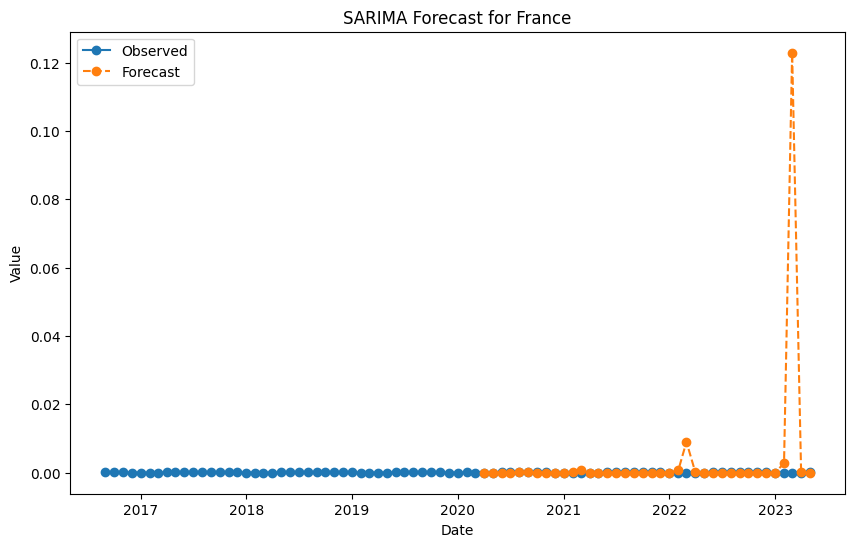

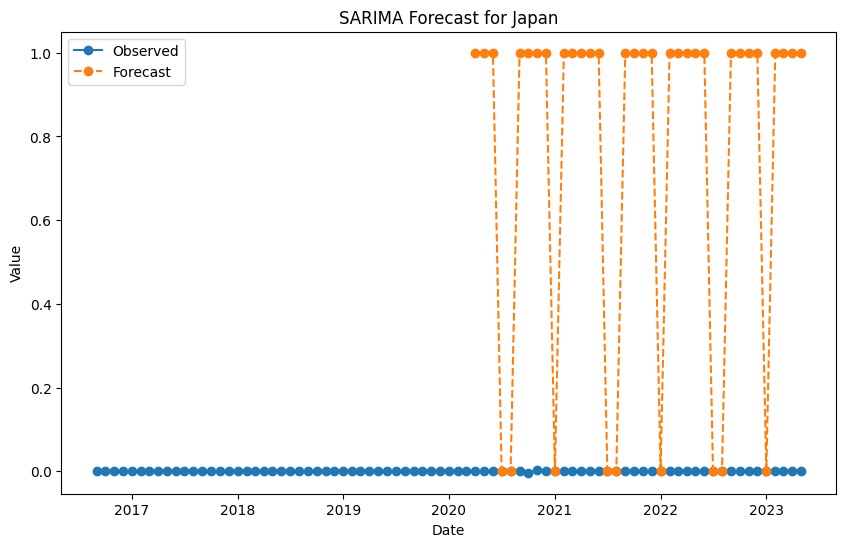

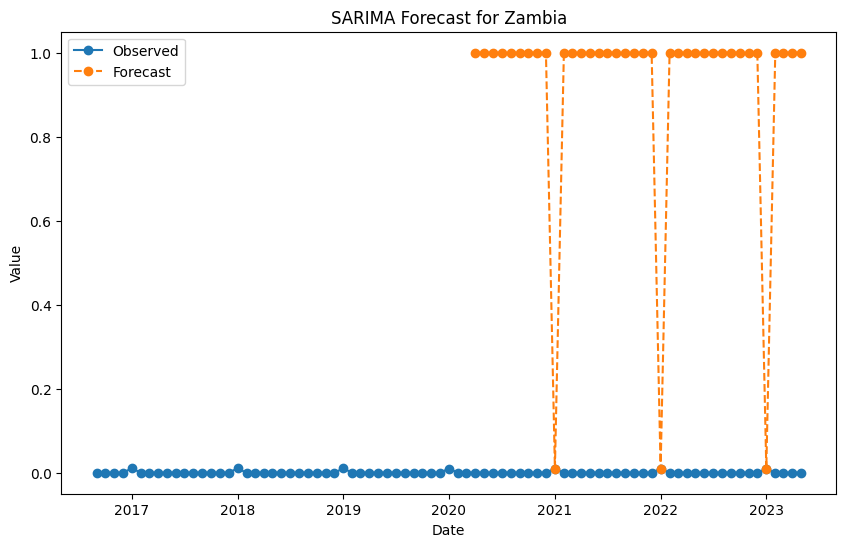

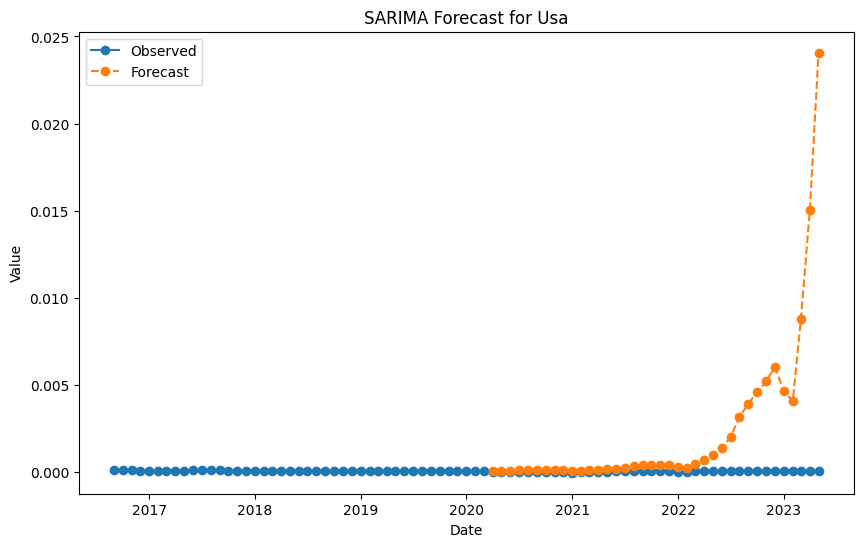

In [175]:
def sarima_forecast(data, best_params_dict, cutoff=None):
    if cutoff is None:
        cutoff_date = pd.to_datetime('2020-03-01')
    else:
        cutoff_date = pd.to_datetime(cutoff)

    sarima_models = {}

    for column, params in best_params_dict.items():
        series = data[column]

        order = params[:3]
        seasonal_order = params[3:]

        # Apply log transformation to the series
        log_transformed_series = series.apply(lambda x: math.log(x) if x > 0 else 0)

        # Split the data into training and testing based on the cutoff date
        training_data = log_transformed_series[log_transformed_series.index <= cutoff_date]
        testing_data = log_transformed_series[log_transformed_series.index > cutoff_date]

        # Fit a SARIMA model based on the best parameters using the training data
        model = sm.tsa.SARIMAX(training_data, order=order, seasonal_order=seasonal_order)
        sarima_model = model.fit()

        sarima_models[column] = sarima_model

    return sarima_models

def plot_sarima_forecast(data, sarima_models, cutoff_date):
    # Plot the forecasts versus the observations for every country
    for column, sarima_model in sarima_models.items():
        # Forecast future values
        forecast_steps = len(data) - len(data[data.index <= cutoff_date])
        predictions = sarima_model.get_forecast(steps=forecast_steps)

        # Transform the log-scale predictions back to the original scale
        predicted_values = pd.Series(predictions.predicted_mean, index=predictions.row_labels)
        predicted_values = predicted_values.apply(lambda x: math.exp(x))

        # Plotting for each country
        plt.figure(figsize=(10, 6))
        plt.plot(data.index, data[column], label='Observed', marker='o')
        plt.plot(predicted_values.index, predicted_values, label='Forecast', linestyle='--', marker='o')

        plt.title(f'SARIMA Forecast for {column}')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.show()

# Example usage:
# Load your dataset (assuming it's in a DataFrame)
best_params_dict = find_best_sarima_params(data,orders)
sarima_models = sarima_forecast(data, best_params_dict, cutoff='2020-03-01')
plot_sarima_forecast(data, sarima_models, cutoff_date=pd.to_datetime('2020-03-01'))

In [ ]:
#fit le sarima avec les meilleurs params de la dernière étape

##Hybrid ARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used

Test MSE for France: 0.000


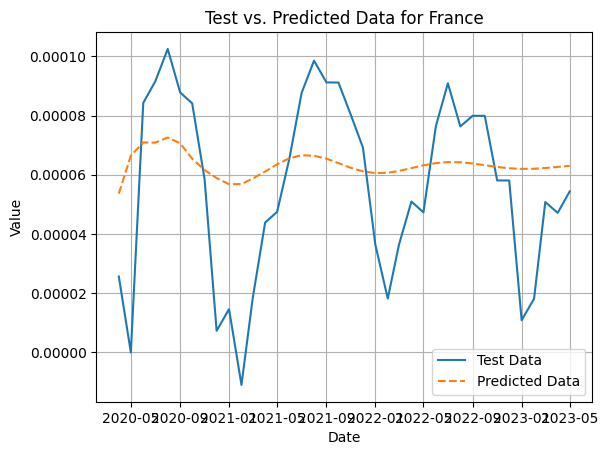

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used

Test MSE for Japan: 0.000


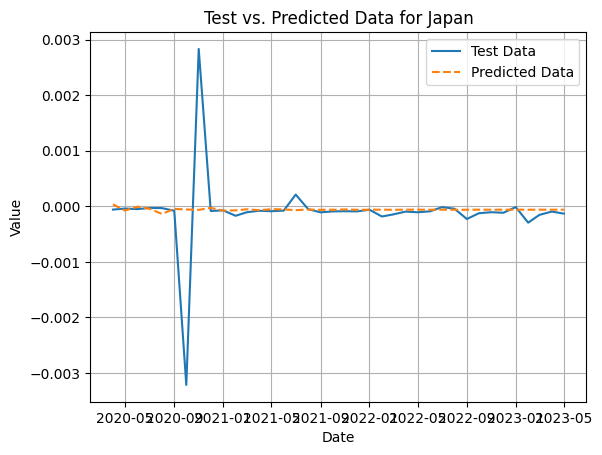

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

Test MSE for Zambia: 0.000


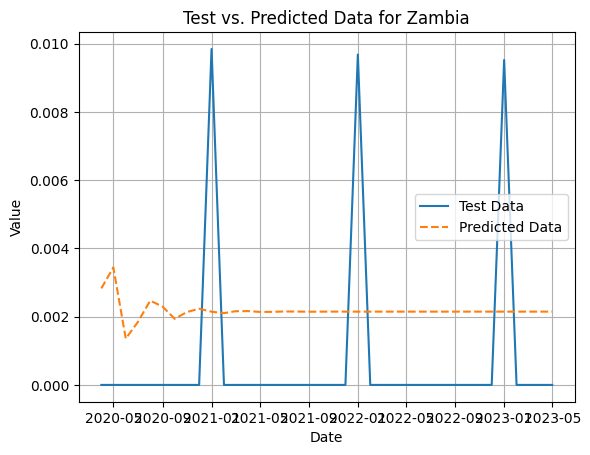

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used

Test MSE for Usa: 0.000


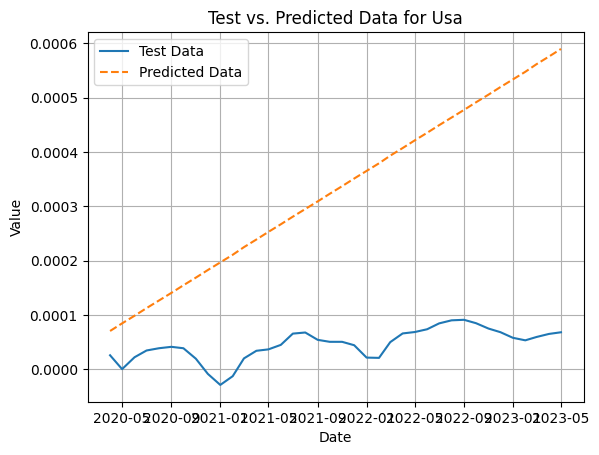

Test Errors:
                  France         Japan    Zambia       Usa
Date                                                      
2020-04-01 -2.798515e-05 -9.448462e-05 -0.002829 -0.000045
2020-05-01 -6.641835e-05  3.534442e-05 -0.003442 -0.000084
2020-06-01  1.335874e-05 -4.418225e-05 -0.001357 -0.000076
2020-07-01  2.070260e-05  1.308390e-05 -0.001840 -0.000078
2020-08-01  2.992169e-05  1.040574e-04 -0.002470 -0.000088
2020-09-01  1.716345e-05 -3.166391e-05 -0.002293 -0.000099
2020-10-01  1.868298e-05 -3.156973e-03 -0.001938 -0.000116
2020-11-01 -3.101944e-06  2.895751e-03 -0.002138 -0.000149
2020-12-01 -5.156676e-05 -5.579611e-05 -0.002233 -0.000191
2021-01-01 -4.218865e-05  4.420161e-06  0.007700 -0.000225
2021-02-01 -6.781700e-05 -9.801847e-05 -0.002103 -0.000223
2021-03-01 -4.044770e-05 -5.294870e-05 -0.002159 -0.000205
2021-04-01 -1.723706e-05 -9.811002e-06 -0.002164 -0.000205
2021-05-01 -1.604197e-05 -3.635901e-05 -0.002140 -0.000216
2021-06-01  1.362194e-07 -2.276759e-05 -0.0

In [158]:

def find_best_order_single_column(train_data, test, column, orders, d=None, max_ar=2, max_ma=2):
    d = orders.get(column, 0) if d is None else d
    best_order = None
    best_aic = float('inf')

    for p in range(0, max_ar + 1):
        for q in range(0, max_ma + 1):
            training_data = train_data
            testing_data = test

            model = ARIMA(training_data, order=(p, d, q))
            arima_model = model.fit()
            aic = arima_model.aic

            if aic < best_aic:
                best_aic = aic
                best_order = (p, d, q)

    return best_order

def hybrid_arima(data ):
    test_errors = pd.DataFrame()  # DataFrame to store test errors
    training_errors = pd.DataFrame()  # DataFrame to store training errors
    predictions_df = pd.DataFrame()  # DataFrame to store predictions
    test_set = pd.DataFrame()

    log_transformed_data = np.log1p(data)  # Apply log transformation to the entire dataset
    cutoff_date = pd.to_datetime('2020-03-01')

    for column in data.columns:
        train = log_transformed_data[column][log_transformed_data.index <= cutoff_date]
        test = log_transformed_data[column][log_transformed_data.index > cutoff_date]

        # Find the best order
        best_order = find_best_order_single_column(train, test, column, orders, max_ar=max_ar, max_ma=max_ma)

        # Fit the ARIMA model
        model = ARIMA(train, order=best_order)
        fitted_model = model.fit()

        # Forecast all test values
        predictions = fitted_model.forecast(steps=len(test))

        # Calculate errors
        error_list = np.expm1(test) - np.expm1(predictions)
        test_error = mean_squared_error(np.expm1(test), np.expm1(predictions))
        training_error = mean_squared_error(np.expm1(train), np.expm1(fitted_model.fittedvalues))

        # Store the test errors
        test_errors[column] = error_list

        # Store the training errors
        training_errors[column] = np.expm1(train) - np.expm1(fitted_model.fittedvalues)

        # Store the predictions
        predictions_df[column] = np.expm1(predictions)

        test_set[column] = np.expm1(test)

        print(f'Test MSE for {column}: %.3f' % test_error)
        plt.plot(test.index, np.expm1(test), label='Test Data')
        plt.plot(predictions.index, np.expm1(predictions), label='Predicted Data', linestyle='--')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.title(f'Test vs. Predicted Data for {column}')
        plt.legend()
        plt.grid(True)
        plt.show()

    return test_errors, training_errors, predictions_df, test_set

# Example usage:
# Assuming 'data' is a DataFrame containing multiple columns of time series data
# Replace 'data' with your actual dataset

test_errors, training_errors, predictions_df,test_s = hybrid_arima(data)

# Access the DataFrames with test errors, training errors, and predictions
print("Test Errors:")
print(test_errors)

print("\nTraining Errors:")
print(training_errors)

print("\nPredictions:")
print(predictions_df)


In [159]:

# Assuming you have defined training_residuals as a DataFrame with one column per country
test_pred = pd.DataFrame()

# Define the model
model = Sequential()
model.add(Dense(64, activation='tanh', input_shape=(1,)))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Iterate over columns (countries) in training_residuals
for i in training_errors.columns:
    train_resid = training_errors[i].values.reshape(-1, 1)
    test_resid = test_errors[i].values.reshape(-1, 1)

    scaler = StandardScaler()
    train_resid = scaler.fit_transform(train_resid)
    test_resid = scaler.transform(test_resid)

    # Use the same model for all countries
    model.fit(train_resid, train_resid, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

    # Predict test values
    test_predictions = model.predict(test_resid)

    # Inverse transform the predictions
    test_predictions = scaler.inverse_transform(test_predictions)

    # Store predictions in the DataFrame
    test_pred[i] = test_predictions.flatten()


2/2 [==============================] - 0s 6ms/step


In [116]:
test_pred

,France,Japan,Zambia,Usa
0,-2.904314e-06,0.000102,0.000005,-0.000035
1,-2.583182e-05,0.000121,0.000005,-0.000052
2,2.865371e-05,0.000111,0.000005,-0.000038
3,2.030667e-05,0.000131,0.000005,-0.000026
4,1.989460e-05,0.000129,0.000005,-0.000021
5,2.117932e-06,0.000081,0.000005,-0.000018
6,1.333090e-05,-0.000424,0.000005,-0.000021
7,1.532594e-06,0.000404,0.000005,-0.000040
8,-3.883516e-05,0.000075,0.000005,-0.000055
9,-3.633103e-05,0.000088,0.010033,-0.000061


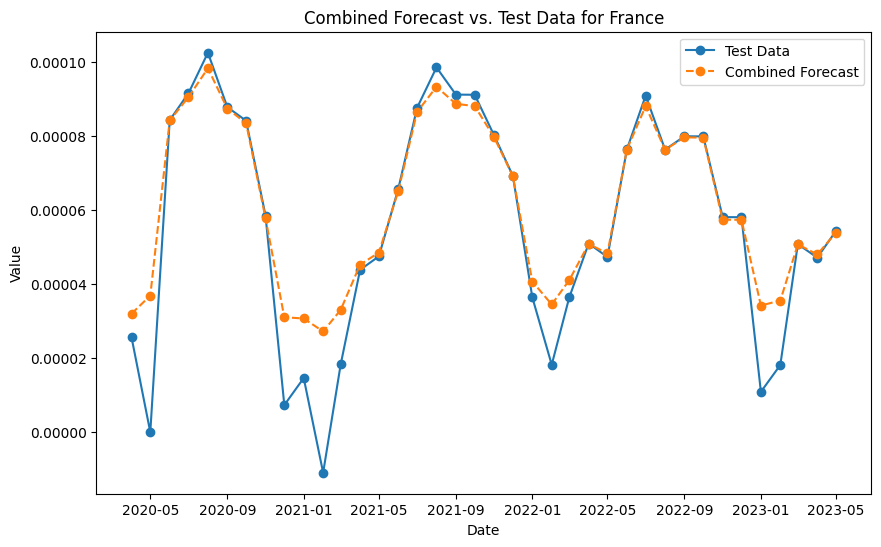

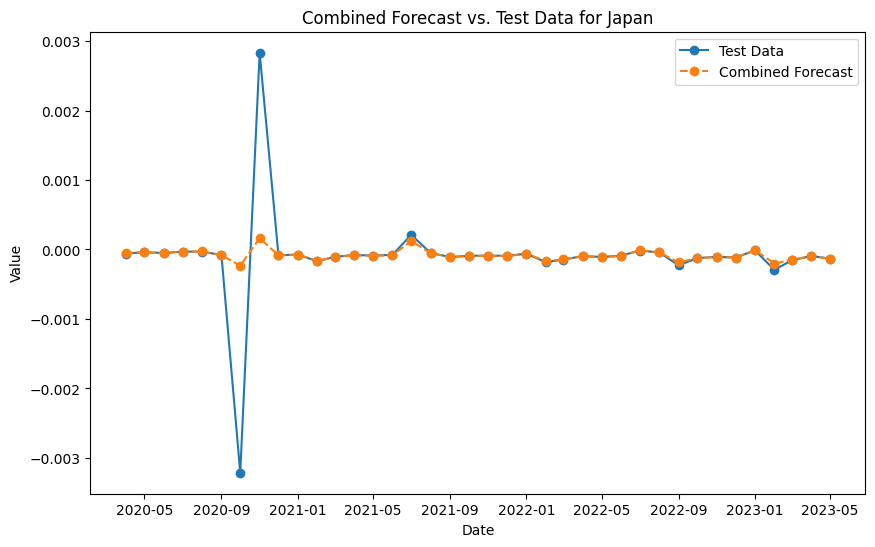

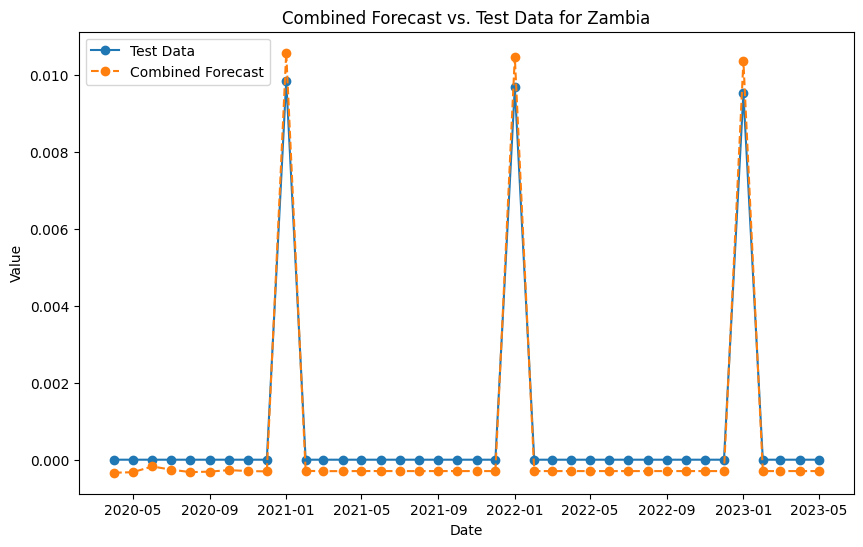

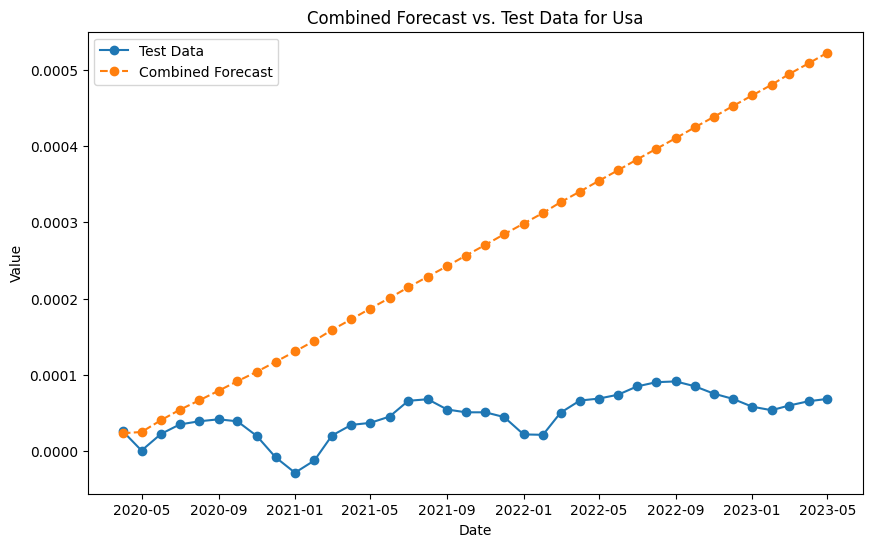

              France     Japan    Zambia       Usa
Date                                              
2020-04-01  0.000032 -0.000052 -0.000338  0.000023
2020-05-01  0.000037 -0.000038 -0.000325  0.000025
2020-06-01  0.000084 -0.000054 -0.000176  0.000040
2020-07-01  0.000091 -0.000031 -0.000258  0.000054
2020-08-01  0.000098 -0.000029 -0.000323  0.000066
2020-09-01  0.000087 -0.000083 -0.000310  0.000079
2020-10-01  0.000083 -0.000232 -0.000271  0.000092
2020-11-01  0.000058  0.000163 -0.000295  0.000104
2020-12-01  0.000031 -0.000087 -0.000304  0.000117
2021-01-01  0.000031 -0.000074  0.010575  0.000131
2021-02-01  0.000027 -0.000163 -0.000291  0.000145
2021-03-01  0.000033 -0.000109 -0.000297  0.000159
2021-04-01  0.000045 -0.000082 -0.000297  0.000173
2021-05-01  0.000049 -0.000092 -0.000295  0.000187
2021-06-01  0.000065 -0.000082 -0.000295  0.000201
2021-07-01  0.000086  0.000121 -0.000296  0.000215
2021-08-01  0.000093 -0.000052 -0.000296  0.000229
2021-09-01  0.000089 -0.000112 

In [160]:
# Assuming 'test' is your observed test data

# Create a DataFrame to store combined forecasts for each country
combined_forecasts = pd.DataFrame(index=test_s.index)

# Iterate over columns (countries)
for column in predictions_df.columns:
    final_forecasts = predictions_df[column].values + test_pred[column].values

    # Plotting for each country
    plt.figure(figsize=(10, 6))
    plt.plot(test_s.index, test_s[column], label='Test Data', marker='o')
    plt.plot(test_s.index, final_forecasts, label='Combined Forecast', linestyle='--', marker='o')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'Combined Forecast vs. Test Data for {column}')
    plt.legend()
    plt.show()

    # Store the combined forecasts in the DataFrame
    combined_forecasts[column] = final_forecasts

# Display the combined forecasts DataFrame
print(combined_forecasts)


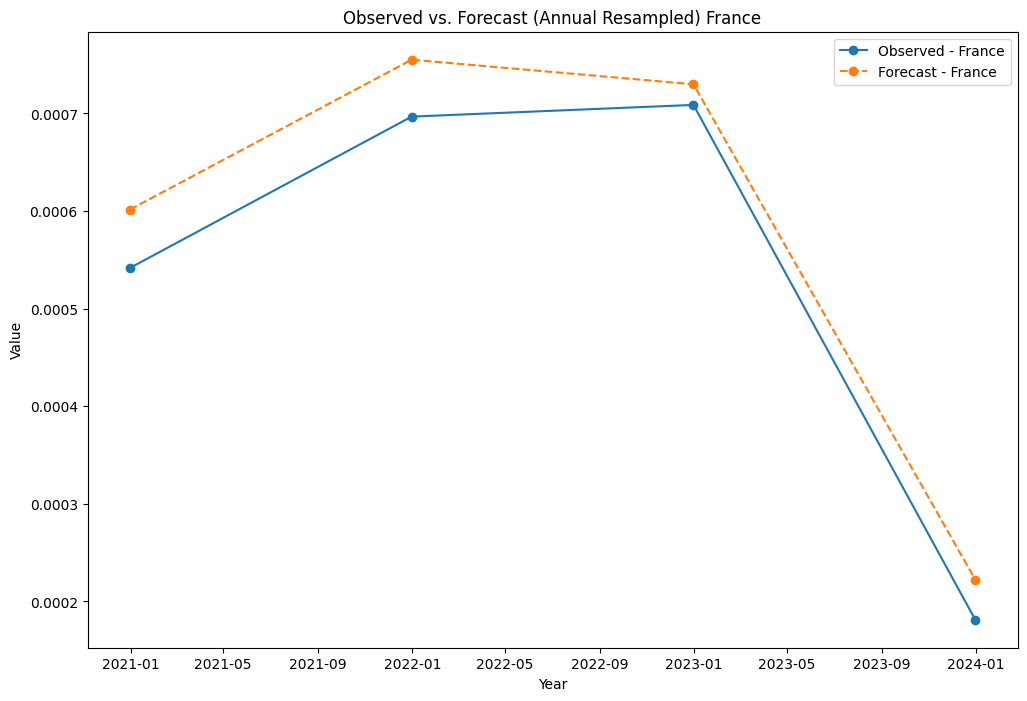

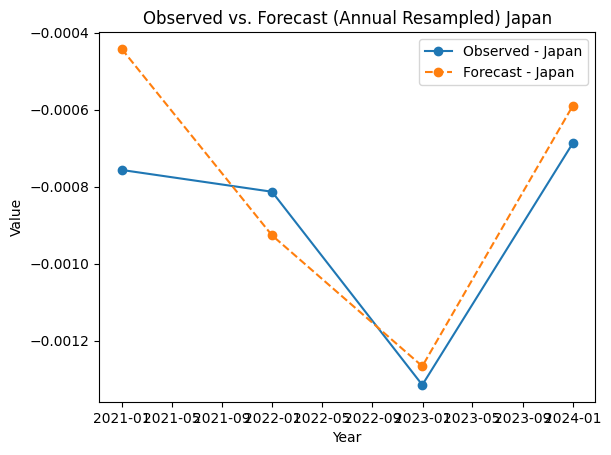

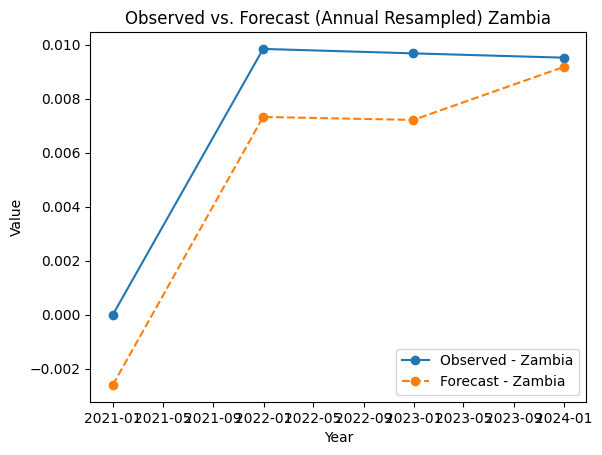

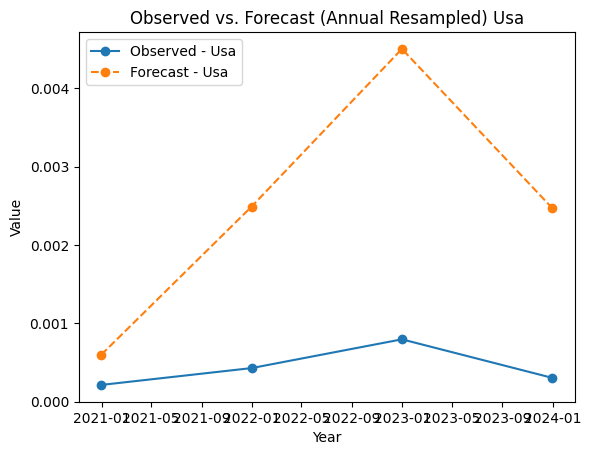

In [179]:
# Assuming 'test_s' is your observed test data
# Resample the observed test data to annual frequency
test_s_annual = test_s.resample('A').sum()

# Plot the observed vs. forecast values for each country
plt.figure(figsize=(12, 8))
for column in combined_forecasts_annual.columns:
    plt.plot(test_s_annual.index, test_s_annual[column], label=f'Observed - {column}', marker='o')
    plt.plot(combined_forecasts_annual.index, combined_forecasts_annual[column], label=f'Forecast - {column}', linestyle='--', marker='o')

    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.title(f'Observed vs. Forecast (Annual Resampled) {column}')
    plt.legend()
    plt.show()
